In [148]:
import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def Weight(F):
    
    w_low = np.where(F <= transition_low, W_stop, 0)
    w_high = np.where(F >= transition_high, W_pass, 0)
    W = w_low + w_high
    
    return W

def get_M(F):
    
    W = Weight(F)
    M = np.cos(F.reshape(k+2,1) * np.arange(k+1) * 2 * np.pi)
    W_inv = np.reciprocal(W) * np.array([(-1) ** x for x in range(k+2)])
    M = np.concatenate((M, W_inv.reshape(k+2,1)), axis = 1)
    
    return M

def get_Hd(F):
    
    H = np.array(F > mid) * 1
    
    return H

def get_R(F,s):
    
    n = len(F)
    R = np.cos(F.reshape(n, 1) * np.arange(k+1) * 2 * np.pi)
    R = np.matmul(R, s)

    return R

def get_err(F, s):
    
    Hd = get_Hd(F)
    W = Weight(F)
    R = get_R(F, s)
    err = (R - Hd) * W
    
    return err

def find_peak(err):
    
    err_shiftRight = np.concatenate(([0], err[:-1]))
    err_shiftLeft = np.concatenate((err[1:], [0]))
    peak_check = (err - err_shiftLeft) * (err - err_shiftRight)
    F_peak = np.array([x for x,y in enumerate(peak_check) if y > 0], dtype = 'uint32')
    P = F_peak[1:-1] # avoid boundary first
    number_select = len(P)
    
    Boundary_right = n_sample - 1

    if number_select == k:
        P = F_peak
    elif number_select == k + 1:
        if F_peak[0] == 0 and F_peak[-1] == Boundary_right:
            x = 0 if abs(err[0]) > abs(err[Boundary_right]) else Boundary_right
            P = np.append(P, x)
            P = np.sort(P)
            
        elif F_peak[0] != 0 and F_peak[-1] == Boundary_right:
            P = np.concatenate((F_peak[0], P))
            
        else:
            P = np.append(P, F_peak[-1])
    else:
        P = P[-(k + 2):] # pick the last k+2 elements from passband to stopband
    
    return F_sample[P]

def plot(curve, title=''):
    
    figure(figsize=(6, 4))
    plt.title(title)
    
    if title == 'Frequency Response':

        x = F_sample
        Hd_F = get_Hd(F_sample)
        plt.plot(x, curve, color='red', label='Frequency Response')
        plt.plot(x, Hd_F, color='blue', label='Hd')
        plt.xlim(0, 0.5)
        plt.ylim(-0.2, 1.2)
        plt.xlabel('Normalized Frequency')
        plt.grid(axis='y')
        plt.legend()
        plt.savefig("Frequency_Response.png")
        plt.show()
        
        
    elif title == 'Impulse Response':
        x = list(range(N))
        plt.stem(x, curve, linefmt=None, markerfmt=None, basefmt=None, use_line_collection=True, label='h[n]')
        plt.ylim(-0.4, 0.7)
        plt.xlabel('N')
        plt.grid(axis='y')
        plt.xticks(x)
        plt.legend()
        plt.savefig("Impulse_Response.png")
        plt.show()

### Initialization

In [74]:
N = 19 #filter lenth
k = int((N - 1) / 2) # mid point index = 9
n_sample = 5001
F_sample = np.linspace(0, 0.5, n_sample)
fs = 4000 #sampling frequency

# Transition band

transition_low = 700 
transition_high = 900
mid = (transition_low + transition_high) / 2

# Normalization

transition_low = transition_low / fs # 0.175
transition_high = transition_high / fs # 0.225
mid = mid / fs # 0.2

# Weighting function
W_pass = 1
W_stop = 0.5

delta = 0.0001
print(transition_low, transition_high, mid)

0.175 0.225 0.2


### Find k+2 Extreme Points

In [75]:
# Step 1, Choose arbitrary k+2 extreme frequencies in the range of (0, 0.5), transtion band excluded

n_extreme = int(k+2)
n_low = int(n_extreme / 2)
n_high = int(n_extreme / 2) if n_extreme%2==0 else int(n_extreme / 2) + 1 

Fm_low = np.linspace(0, transition_low, n_low)
Fm_high = np.linspace(transition_high, 0.5, n_high)
Fm = np.concatenate((Fm_low, Fm_high))

E1 = float("inf")
iteration = 0
while(True):
    iteration += 1
    
    # Step 2: Compute s[n]
    Hd = get_Hd(Fm)
    M = get_M(Fm)
    s = np.matmul(inv(M), Hd)[:-1]
    R = get_R(Fm,s)
    
    # Step 3: Compute err(F) for 0 <= F <= 0.5, exclude the transition band.
    
    err_F = get_err(F_sample, s)
    
    # Step 4: Find k+2 local maximal (or minimal) points of err(F)
    
    ExtremePoints = find_peak(err_F)
    
    # Step 5:
    
    E0 = np.amax(abs(err_F))
    print("Iteration %d , Max Error = %.4f" %(iteration, E0))
    
    if E1 - E0 <= delta and E1 - E0 >= 0:
        break
    else:
        E1 = E0
        Fm = ExtremePoints

Iteration 1 , Max Error = 0.1595
Iteration 2 , Max Error = 0.1048
Iteration 3 , Max Error = 0.1668
Iteration 4 , Max Error = 0.1120
Iteration 5 , Max Error = 0.0505
Iteration 6 , Max Error = 0.0500
Iteration 7 , Max Error = 0.0500


### Print The Result

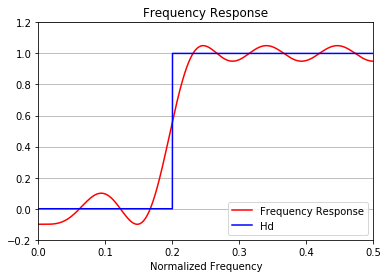

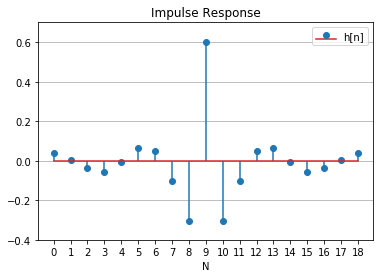

[ 0.03675292  0.00476091 -0.03761305 -0.05483019 -0.00661827  0.06400339
  0.05059447 -0.10074927 -0.30558892  0.59866141 -0.30558892 -0.10074927
  0.05059447  0.06400339 -0.00661827 -0.05483019 -0.03761305  0.00476091
  0.03675292]


In [149]:
# Step 6: Calculate h[n], print Frequency Response and Impulse Response

R_F  = get_R(F_sample, s)
plot(R_F, title='Frequency Response')

hn = np.zeros(N)
hn[k] = s[0]

for i in range(1,k+1):
    hn[k+i] = s[i] / 2
    hn[k-i] = s[i] / 2
    
plot(hn, title='Impulse Response')
print(hn)